<a href="https://colab.research.google.com/github/copev313/Deep-Learning-Introduction/blob/main/overfitting-and-underfitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overfitting & Underfitting

---


## Introduction #

In this exercise, you’ll learn how to improve training outcomes by including an early stopping callback to prevent overfitting.


In [1]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')


First load the *Spotify* dataset. Your task will be to predict the popularity of a song based on various audio features, like `'tempo'`, `'danceability'`, and `'mode'`.

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']

features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

'''
Do a "grouped" split to keep all of an artist's songs in one split or the
other. This is to help prevent signal leakage.
'''
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

# Popularity is on a scale 0-100, so this rescales to 0-1:
y_train = y_train / 100 
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))


Input shape: [18]


Let's start with the simplest network, a linear model. This model has low capacity.

Run this next cell without any changes to train a linear model on the *Spotify* dataset.

Minimum Validation Loss: 0.1916


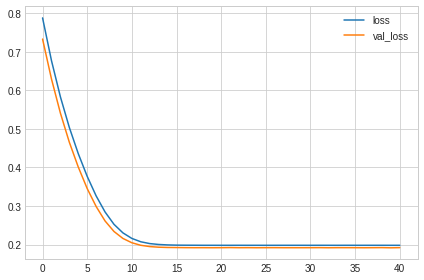

In [6]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])

model.compile(
    optimizer='adam',
    loss='mae',
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[0:40, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

It's not uncommon for the curves to follow a "hockey stick" pattern like you see here. This makes the final part of training hard to see, so let's start at epoch 10 instead:

Minimum Validation Loss: 0.1916


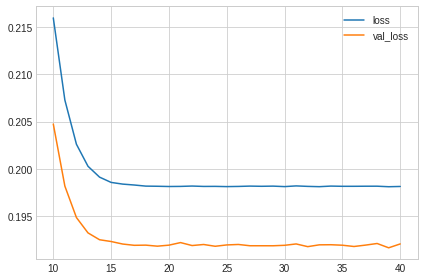

In [8]:
# Start the plot at epoch 10:
history_df.loc[10:40, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

## 1) Evaluate Baseline

What do you think? Would you say this model is underfitting, overfitting, just right?

Now let's add some capacity to our network. We'll add three hidden layers with 128 units each. Run the next cell to train the network and see the learning curves.

Epoch 1/50
49/49 [==============================] - 1s 7ms/step - loss: 0.2178 - val_loss: 0.1973
Epoch 2/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1996 - val_loss: 0.1939
Epoch 3/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1958 - val_loss: 0.1927
Epoch 4/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1932 - val_loss: 0.1912
Epoch 5/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1912 - val_loss: 0.1912
Epoch 6/50
49/49 [==============================] - 0s 5ms/step - loss: 0.1898 - val_loss: 0.1939
Epoch 7/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1899 - val_loss: 0.1914
Epoch 8/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1880 - val_loss: 0.1898
Epoch 9/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1864 - val_loss: 0.1929
Epoch 10/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1858 - val_loss: 0.1913
Epoch 11/50
49/49 [

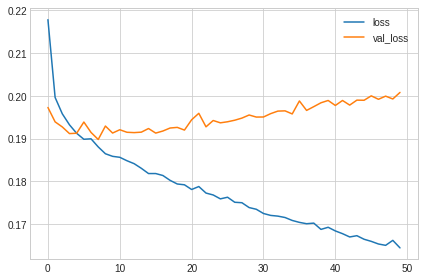

In [9]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mae',
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

## 2) Add Capacity

What is your evaluation of these curves? Underfitting, overfitting, just right?

## 3) Define Early Stopping Callback

Now define an early stopping callback that waits 5 epochs (`patience'`) for a change in validation loss of at least `0.001` (`min_delta`) and keeps the weights with the best loss (`restore_best_weights`).

In [10]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True,
)


Now run this cell to train the model and get the learning curves. Notice the `callbacks` argument in `model.fit`.

Epoch 1/50
49/49 [==============================] - 1s 7ms/step - loss: 0.2535 - val_loss: 0.2093
Epoch 2/50
49/49 [==============================] - 0s 4ms/step - loss: 0.2055 - val_loss: 0.1965
Epoch 3/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1988 - val_loss: 0.1937
Epoch 4/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1955 - val_loss: 0.1924
Epoch 5/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1934 - val_loss: 0.1923
Epoch 6/50
49/49 [==============================] - 0s 5ms/step - loss: 0.1917 - val_loss: 0.1928
Epoch 7/50
49/49 [==============================] - 0s 5ms/step - loss: 0.1902 - val_loss: 0.1907
Epoch 8/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1892 - val_loss: 0.1920
Epoch 9/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1890 - val_loss: 0.1919
Epoch 10/50
49/49 [==============================] - 0s 4ms/step - loss: 0.1876 - val_loss: 0.1914
Epoch 11/50
49/49 [

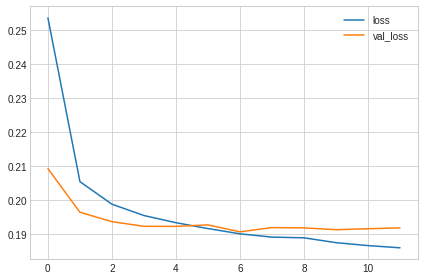

In [11]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mae',
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

## 4) Train and Interpret

Was this an improvement compared to training without early stopping?